# VGGFace (VGG16) Fine Tuning

In [1]:
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import warnings
from keras_vggface_TF.vggfaceTF import VGGFace
from keras_vggface_TF import utils

%matplotlib inline

warnings.filterwarnings('ignore')

2021-11-24 16:07:31.936851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-24 16:07:31.936919: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print('Python Version ' + sys.version)
print('TensorFlow Version ' + tf.__version__)

if int(sys.version[0]) < 3 or int(sys.version[2]) < 7:
    assert("Python version 3.7 or newer is required")
if int(tf.__version__[0]) < 2 or int(tf.__version__[2]) < 3:
    assert("Tensorflow version 2.3 or newer is required")

Python Version 3.9.0 (default, Nov 15 2020, 14:28:56) 
[GCC 7.3.0]
TensorFlow Version 2.6.2


## Setting the parameters

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 300

CUR_PATH = os.path.abspath('')
TRAIN_PATH = CUR_PATH + '/../../../dataset/data/classified'
VALID_PATH = CUR_PATH + '/../../../dataset/data/validation'
TEST_PATH = CUR_PATH + '/../../../dataset/data/test'

classes = {0 : "Baby",
           1 : "Not Baby"}

## Defining Data Augmentation Function

In [4]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

## Defining Data Generators

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          preprocessing_function = data_augment)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True)

val_test_datagen.apply_transform

train_ds = datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed = 1,
        color_mode = 'rgb',
        shuffle = True,
        class_mode='binary')

val_ds = val_test_datagen.flow_from_directory(
        VALID_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode = 'rgb',
        shuffle = True,
        class_mode='binary')

test_ds = val_test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode = 'rgb',
        class_mode='binary')

Found 135 images belonging to 2 classes.
Found 31 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


2021-11-24 16:07:45.656074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-24 16:07:45.656161: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-24 16:07:45.656235: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (snf-22339): /proc/driver/nvidia/version does not exist
2021-11-24 16:07:45.657079: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


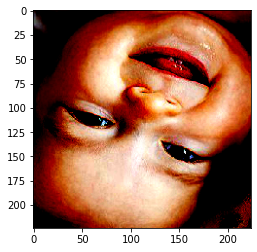

In [6]:
x = train_ds.next()
image = x[0][0]
print(image.shape)
plt.imshow(image)

In [7]:
cat_img = plt.imread(TRAIN_PATH + '/baby/1.jpeg')

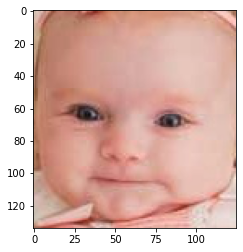

In [8]:
plt.imshow(cat_img)

## Loading the VGGFace model

In [9]:
vgg_model = VGGFace(model='vgg16', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg') 
vgg_model.trainable = False

## Creating the model

In [10]:
x = tf.keras.layers.Flatten(name='flatten')(vgg_model.output)
x = tf.keras.layers.Dense(32, activation='relu',)(x)
x = tf.keras.layers.Dense(16, activation='relu',)(x)
out = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(x)
custom_vgg_model = tf.keras.Model(vgg_model.input, out)

custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

## Defining Callbacks

In [11]:
learning_rate = 1e-4

optimizer = tf.optimizers.Adam(learning_rate = learning_rate)

custom_vgg_model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.binary_crossentropy, 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_ds.n // train_ds.batch_size
# STEP_SIZE_VALID = val_ds.n // val_ds.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 # verbose = 1,
                                                 factor = 0.2,
                                                 patience = 10,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'min')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 # verbose = 1,
                                                 min_delta = 1e-4,
                                                 patience = 30,
                                                 mode = 'min',
                                                 restore_best_weights = True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(monitor = 'val_loss',
                                                  # verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'min',
                                                  filepath = './model_vgg_vgg16.hdf5',
                                                  )

callbacks = [checkpointer, earlystopping, reduce_lr] #reduce_lr earlystopping

## Training the Model

In [12]:
custom_vgg_model.fit(x = train_ds,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_ds,
          epochs = EPOCHS,
          callbacks = callbacks)

custom_vgg_model.save('model_vggface_vgg_ft.h5')

2021-11-24 16:07:54.389568: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
8/8 [==============================] - 11s 1s/step - loss: 0.6895 - accuracy: 0.4622 - val_loss: 0.6892 - val_accuracy: 0.5484
Epoch 2/300
8/8 [==============================] - 10s 1s/step - loss: 0.6888 - accuracy: 0.4531 - val_loss: 0.6888 - val_accuracy: 0.5484
Epoch 3/300
8/8 [==============================] - 9s 1s/step - loss: 0.6872 - accuracy: 0.4538 - val_loss: 0.6886 - val_accuracy: 0.5484
Epoch 4/300
8/8 [==============================] - 9s 1s/step - loss: 0.6848 - accuracy: 0.5126 - val_loss: 0.6881 - val_accuracy: 0.5484
Epoch 5/300
8/8 [==============================] - 9s 1s/step - loss: 0.6860 - accuracy: 0.5546 - val_loss: 0.6873 - val_accuracy: 0.5484
Epoch 6/300
8/8 [==============================] - 9s 1s/step - loss: 0.6835 - accuracy: 0.5378 - val_loss: 0.6860 - val_accuracy: 0.5484
Epoch 7/300
8/8 [==============================] - 9s 1s/step - loss: 0.6853 - accuracy: 0.5798 - val_loss: 0.6851 - val_accuracy: 0.5484
Epoch 8/300
8/8 [===============

In [13]:
# test_model = tf.keras.models.load_model("model_vggface_vgg_ft.h5")

In [14]:
# test_model.evaluate(test_ds)

## Evaluating the model on test set

In [15]:
custom_vgg_model.evaluate(test_ds)

2/2 [==============================] - 1s 125ms/step - loss: 0.2179 - accuracy: 1.0000


[0.2179417759180069, 1.0]

In [16]:
res = custom_vgg_model.predict(test_ds)

In [17]:
res

array([[0.28537428],
       [0.94028354],
       [0.9002596 ],
       [0.90482366],
       [0.19914293],
       [0.14602393],
       [0.8919655 ],
       [0.27555317],
       [0.38633934],
       [0.8440929 ],
       [0.8218801 ],
       [0.9027069 ],
       [0.77538216],
       [0.03124008],
       [0.18736705],
       [0.18895379],
       [0.50154805],
       [0.8570397 ]], dtype=float32)

In [18]:
res[res >= 0.5] = 1

In [19]:
res[res < 0.5] = 0

In [20]:
res

array([[0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float32)